#### Practical strategies for ships passing limited water depth to achieve multiple goals
- Strategies include vessel sailing velocities, payload adjustment(actual draught), parcial engine load
- multiple goals covers the indicators of fuel use, emissions (CO2, PM10, NOx), transport time, safefy (represented by the remaining space between ship bottom and the bed of the waterway). 

##### Steps
- present a waterway section with limited water depth (150 km with 2.5 m water depth) on the graph
- provide a list of feasible draughts according to vessel size, water depth and safety margin (minimum ukc) prevent grounding
- use get_v funtion to get maximum feasible velocity considering both installed enegine power and ship squat while moving at a speed
- for each possible T&V combination, incorporate energy module, output a table with results of all the indicators
- use 'Parallel coordinate plot' to visualise strategies
- Automatically select optimal strategies to achieve the goal of less transport time, less emissions, less fuel use, safety guarantees.

In [1]:

# spatial libraries
import shapely.geometry
import pyproj

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt
import requests
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go

import functools
import itertools
import warnings
warnings.filterwarnings('ignore')
import sys
sys.tracebacklimit=0
# package(s) related to time, space and id
import logging
import datetime, time
import platform

# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling

import scipy.optimize
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import tqdm

# Used for mathematical functions
import math             

import plotly.express as px
from plotly.subplots import make_subplots

#logging.basicConfig(level=logging.DEBUG) #turn on all the debug messages
#logging.basicConfig(level=logging.INFO)# turn off all the debug messages

logger = logging.getLogger('notebook')

# Used for making the graph
import networkx as nx

# OpenTNSim
import opentnsim


#### Present the waterway section with limited water depth on the graph network

In [2]:
# We're in engineering cordinates (m)
coords = [
    [0,0],
    [0.8983,0], 
    [1.7966,0],
    [1.7966,1.3566],
    [1.7966,2.2609],
    [2.7527,0.9560],
    [3.3903,1.5931],
    [3.1441,0],
    
    [4.0424, 0],
    [1.9560,-0.1693],
    [3.3904,-1.5931]] 


# these are the indices of the points above
edge_indices = [
    [0, 1],
    [1, 2],
    [2, 3],
    [3, 4],
    [2, 5],
    [5, 6],
    [2, 7],
    [7, 8],
    [2, 9],
    [9, 10]   
]

depths = [12.5, 6, 6, 6, 4.5, 6, 2.5, 6, 2.5, 6] 

widths = [300, 150, 150, 150, 150, 150, 150, 150, 150, 150]

points = [
    shapely.geometry.Point(*coord )
    for coord 
    in coords
]

In [3]:
# define Site class
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

In [4]:
FG = nx.DiGraph()

nodes = []
for index, coord in enumerate(coords):
    data_node = {"name": str(index), "geometry": shapely.geometry.Point(points[index].x, points[index].y)}
    nodes.append(Node(**data_node))

for node in nodes:
    FG.add_node(node.name, geometry = node.geometry)    
    
for index, edge in enumerate(edge_indices):
    edge_geometry = shapely.geometry.LineString([points[edge[0]], points[edge[1]]])
    edge_properties = dict(
        GeneralDepth = depths[index],
        width = widths[index],
        geometry = edge_geometry, 
        length = round(edge_geometry.length),
        e = tuple(edge)
    )
    FG.add_edge( str(edge[0]), str(edge[1]), weight = 1, Info = edge_properties)

# toggle to undirected and back to directed to make sure all edges are two way traffic
FG = FG.to_undirected() 
FG = FG.to_directed() 

In [5]:
positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)

In [6]:
# collect node labels.
labels = {}
for node in FG.nodes:
    labels[node] = node

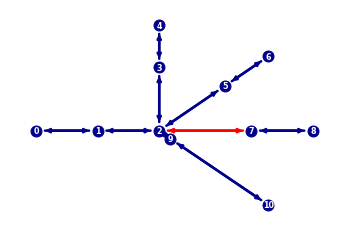

In [7]:
# draw edges, nodes and labels.
colors =['darkblue','darkblue','darkblue','darkblue','darkblue','darkblue','r','darkblue','darkblue','darkblue','darkblue','darkblue','darkblue','darkblue','r','darkblue','darkblue','darkblue','darkblue','darkblue']
nx.draw_networkx_edges(FG,  pos=positions, width=2.5, edge_color=colors, alpha=1, arrowsize=8)
nx.draw_networkx_nodes(FG,  pos=positions, node_color="darkblue", node_size=120)
nx.draw_networkx_labels(FG, pos=positions, labels=labels, font_size=8, font_weight='bold', font_color="white")

plt.axis("off")
plt.savefig('graph_limited_water_depth.pdf', bbox_inches = 'tight', dpi=600, format='pdf') 
plt.show()

#### Create vessel - add VesselProperties and ConsumesEnergy mixins

In [8]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.Routeable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.energy.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [9]:
# Create a dict with all important settings
data_vessel = {
               "env": None,
               "name": None,
               "route": None,
               "geometry": None,
               "v": None,  # m/s
               "type":  None, # <-- note that inputs from hereon are due to the added mixins!
               "B": 11.4,
               "L": 110,
               "H_e": None, 
               "H_f": None, 
               "T": 2.05,
               "safety_margin": 0.2, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
               "h_squat":True,
               "P_installed": 1750.0,   
               "P_tot_given": None, # kW
               "bulbous_bow": False, # if a vessel has no bulbous_bow, set to none; otherwise set to 1.
               "P_hotel_perc": 0.05,
               "P_hotel": None, # None: calculate P_hotel from percentage
               "x": 2,# number of propellers
               "L_w": 3.0 ,
               "C_B":0.85, 
               "C_year":1990,
              }        
data_vessel_i = data_vessel.copy()
vessel = TransportResource(**data_vessel_i)

In [10]:
draught = opentnsim.strategy.Payload2T(vessel= vessel, Payload_strategy=1056, vessel_type= "Tanker")
draught 

1056 2835.234847122788 7.639320225002102 Tanker
1056 2835.234847122788 12.360679774997894 Tanker
1056 2835.234847122788 15.278640450004204 Tanker
1056 2835.234847122788 17.08203932499369 Tanker
1056 2835.234847122788 18.196601125010513 Tanker
1056 2835.234847122788 18.885438199983174 Tanker
1056 2835.234847122788 19.31116292502734 Tanker
1056 2835.234847122788 19.574275274955838 Tanker
1056 2835.234847122788 19.736887650071505 Tanker
1056 2835.234847122788 19.837387624884336 Tanker
1056 2835.234847122788 19.899500025187173 Tanker
1056 2835.234847122788 19.937887599697163 Tanker
1056 2835.234847122788 19.961612425490006 Tanker
1056 2835.234847122788 19.976275174207156 Tanker
1056 2835.234847122788 19.985337251282854 Tanker
1056 2835.234847122788 19.990937922924303 Tanker
1056 2835.234847122788 19.994399328358547 Tanker
1056 2835.234847122788 19.996538594565756 Tanker
1056 2835.234847122788 19.997860733792795 Tanker
1056 2835.234847122788 19.998677860772965 Tanker
1056 2835.234847122788 

19.99999335625205

#### Provide a group of feasible draughts according to vessel size, water depth and safety margin (minimum ukc) prevent grounding
here we choose M8 vessel as it has a large share of the sailing movements per year on waal (Rijkswaterstaat,2021, Safety aspects of new energy carriers in inland navigation), M8's draught ranges from 1.4 m to 3.5 m, considering a safety margin (minimum ukc) of 0.2 m at water depth 2.5 m, the final feasible draught ranges from 1.4 m to 2.3 m.

In [11]:
# provide max and min draught
max_draught = 2.30
min_operational_draught = 1.40
stepsize = -0.05

# create lists of strategy values
T_strategy = np.arange(max_draught, round(min_operational_draught + stepsize, 2), stepsize).round(2).tolist()
h_min = [2.5]
safety_margin = [0.2]
width = [150]


In [12]:
# prepare the work to be done by creating a list of all combinations
work = list(itertools.product(T_strategy, h_min, safety_margin, width))

# prepare a list of dictionaries for pandas
rows = []
for item in work:
    row = {"T_strategy": item[0],"h_min":item[1], "safety_margin":item[2], "width":item[3]}
    rows.append(row)

    # these are all the simulations that we want to run

# convert them to dataframe, so that we can apply a function and monitor progress
work_df = pd.DataFrame(rows)
work_df.head(20)

,T_strategy,h_min,safety_margin,width
0,2.30,2.5,0.2,150
1,2.25,2.5,0.2,150
2,2.20,2.5,0.2,150
3,2.15,2.5,0.2,150
4,2.10,2.5,0.2,150
5,2.05,2.5,0.2,150
6,2.00,2.5,0.2,150
7,1.95,2.5,0.2,150
8,1.90,2.5,0.2,150
9,1.85,2.5,0.2,150


#### Caculate the maximum velocity the vessel can sail at for each T_strategy, considering maximum sinkage and installed engine power

In [13]:
Strategies = []

for i, row in tqdm.tqdm(work_df.iterrows(),disable=True):

    # get vessel 
    data_vessel_i = data_vessel.copy()
    vessel = TransportResource(**data_vessel_i)
    vessel._T = row['T_strategy']
    vessel.safety_margin = row['safety_margin']
    
    # estimate 'grounding speed' as a useful upperbound
    upperbound, selected, results_df = opentnsim.strategy.get_upperbound_for_power2v(vessel, width=row['width'], depth=row['h_min'], margin=0)
    
    # calculate the velocity that belongs to the T_strategy (while leaving the margin)
    v, depth, depth_squat, z_computed, margin = opentnsim.strategy.get_v(vessel, width=row['width'], depth=row['h_min'], margin=row['safety_margin'], bounds=(0, upperbound))
    
    # detaremine payload
    Payload_comupted = opentnsim.strategy.T2Payload(vessel, row['T_strategy'], vessel_type = "Tanker") 
    
    Strategy ={}
    Strategy.update(row)
    Strategy['v_upper_bound (m/s)'] = upperbound # power allowed max v   
    Strategy['v_strategy (m/s)'] = v  # final max v considering squat and installed power
    Strategy['z_computed (m)'] = z_computed
    Strategy['depth squat (m)'] = depth_squat
    Strategy['T + margin (m)'] = row['T_strategy']+ row['safety_margin']
    
    Strategy['Payload_strategy_tanker (ton)'] = Payload_comupted
    Strategies.append(Strategy)

In [14]:
Strategies_df = pd.DataFrame(Strategies)
with pd.option_context('display.float_format', '{:.2f}'.format):
    display(Strategies_df)

,T_strategy,h_min,safety_margin,width,v_upper_bound (m/s),v_strategy (m/s),z_computed (m),depth squat (m),T + margin (m),Payload_strategy_tanker (ton)
0,2.30,2.50,0.20,150.00,2.84,0.00,0.00,2.50,2.50,1441.73
1,2.25,2.50,0.20,150.00,3.19,1.58,0.05,2.45,2.45,1384.33
2,2.20,2.50,0.20,150.00,3.48,2.23,0.10,2.40,2.40,1326.99
3,2.15,2.50,0.20,150.00,3.74,2.73,0.15,2.35,2.35,1269.71
4,2.10,2.50,0.20,150.00,3.98,3.17,0.20,2.30,2.30,1212.50
5,2.05,2.50,0.20,150.00,4.15,3.56,0.25,2.25,2.25,1155.35
6,2.00,2.50,0.20,150.00,4.36,3.92,0.30,2.20,2.20,1098.26
7,1.95,2.50,0.20,150.00,4.50,4.27,0.35,2.15,2.15,1041.24
8,1.90,2.50,0.20,150.00,4.57,4.57,0.40,2.10,2.10,984.28
9,1.85,2.50,0.20,150.00,4.68,4.68,0.41,2.09,2.05,927.39


#### Provide a group of feasible velocities for each T_strategy

In [15]:
# provide max and min draught
v_feasible_forT = []
for row in Strategies:
    max_velocity = row['v_strategy (m/s)']
    min_velocity = 1
    stepsize = -0.1
    # create lists of strategy values
    v_feasible = np.arange(max_velocity, round(min_velocity + stepsize, 2), stepsize).round(2).tolist()
    v_feasible_forT.append(v_feasible)
v_df = pd.DataFrame(v_feasible_forT).T
names=['T=2.30','T=2.25','T=2.20','T=2.15','T=2.10','T=2.05','T=2.00','T=1.95','T=1.90','T=1.85','T=1.80','T=1.75','T=1.70','T=1.65','T=1.60','T=1.55','T=1.50','T=1.45','T=1.40']
v_df.columns=names
v_df

,T=2.30,T=2.25,T=2.20,T=2.15,T=2.10,T=2.05,T=2.00,T=1.95,T=1.90,T=1.85,T=1.80,T=1.75,T=1.70,T=1.65,T=1.60,T=1.55,T=1.50,T=1.45,T=1.40
0,NaN,1.58,2.23,2.73,3.17,3.56,3.92,4.27,4.57,4.68,4.72,4.74,4.74,4.73,4.7,4.65,4.59,4.52,4.43
1,NaN,1.48,2.13,2.63,3.07,3.46,3.82,4.17,4.47,4.58,4.62,4.64,4.64,4.63,4.6,4.55,4.49,4.42,4.33
2,NaN,1.38,2.03,2.53,2.97,3.36,3.72,4.07,4.37,4.48,4.52,4.54,4.54,4.53,4.5,4.45,4.39,4.32,4.23
3,NaN,1.28,1.93,2.43,2.87,3.26,3.62,3.97,4.27,4.38,4.42,4.44,4.44,4.43,4.4,4.35,4.29,4.22,4.13
4,NaN,1.18,1.83,2.33,2.77,3.16,3.52,3.87,4.17,4.28,4.32,4.34,4.34,4.33,4.3,4.25,4.19,4.12,4.03
5,NaN,1.08,1.73,2.23,2.67,3.06,3.42,3.77,4.07,4.18,4.22,4.24,4.24,4.23,4.2,4.15,4.09,4.02,3.93
6,NaN,0.98,1.63,2.13,2.57,2.96,3.32,3.67,3.97,4.08,4.12,4.14,4.14,4.13,4.1,4.05,3.99,3.92,3.83
7,NaN,NaN,1.53,2.03,2.47,2.86,3.22,3.57,3.87,3.98,4.02,4.04,4.04,4.03,4.0,3.95,3.89,3.82,3.73
8,NaN,NaN,1.43,1.93,2.37,2.76,3.12,3.47,3.77,3.88,3.92,3.94,3.94,3.93,3.9,3.85,3.79,3.72,3.63
9,NaN,NaN,1.33,1.83,2.27,2.66,3.02,3.37,3.67,3.78,3.82,3.84,3.84,3.83,3.8,3.75,3.69,3.62,3.53


In [16]:
# create a new table of all the v/strategy combinations
# using the itertools.product is more pro
# but for now we'll just loop
rows = []
for strategy in Strategies:
    max_velocity = strategy['v_strategy (m/s)']
    min_velocity = 1
    stepsize = -0.1
    v_feasible = np.arange(max_velocity, round(min_velocity + stepsize, 2), stepsize).round(2)
    for v_feasible_i in v_feasible:
        row = {}
        row.update(strategy)
        row['max_velocity'] = max_velocity
        row['min_velocity'] = min_velocity
        row['stepsize'] = stepsize
        row['v_feasible'] = v_feasible_i
       
        rows.append(row)
v_flat_df = pd.DataFrame(rows)        

    

In [17]:
columns = ['T_strategy', 'v_feasible', 'h_min', 'safety_margin', 'width']
# select relevant info
# these are all the runs that we want to run a simulation 
runs_df = v_flat_df[columns]
runs_df

,T_strategy,v_feasible,h_min,safety_margin,width
0,2.25,1.58,2.5,0.2,150.0
1,2.25,1.48,2.5,0.2,150.0
2,2.25,1.38,2.5,0.2,150.0
3,2.25,1.28,2.5,0.2,150.0
4,2.25,1.18,2.5,0.2,150.0
...,...,...,...,...,...
567,1.40,1.33,2.5,0.2,150.0
568,1.40,1.23,2.5,0.2,150.0
569,1.40,1.13,2.5,0.2,150.0
570,1.40,1.03,2.5,0.2,150.0


In [18]:
# import IPython.display

# T_strategies = v_flat_df.T_strategy.unique()

# def get_v_feasible_for_T(T_strategy):
#     selected_df = v_flat_df[np.isclose(v_flat_df.T_strategy, T_strategy)]
#     columns = ['T_strategy', 'v_feasible', 'h_min', 'safety_margin', 'width']
#     return selected_df[columns]

# runs = []
# for T_strategy in T_strategies:
#     v_feasible_df = get_v_feasible_for_T(T_strategy)
#     runs.append(v_feasible_df)




In [19]:
T_strategy = pd.DataFrame(T_strategy).T 
T_names=['T=2.30','T=2.25','T=2.20','T=2.15','T=2.10','T=2.05','T=2.00','T=1.95','T=1.90','T=1.85','T=1.80','T=1.75','T=1.70','T=1.65','T=1.60','T=1.55','T=1.50','T=1.45','T=1.40']
T_strategy.columns = T_names
T_strategy

,T=2.30,T=2.25,T=2.20,T=2.15,T=2.10,T=2.05,T=2.00,T=1.95,T=1.90,T=1.85,T=1.80,T=1.75,T=1.70,T=1.65,T=1.60,T=1.55,T=1.50,T=1.45,T=1.40
0,2.3,2.25,2.2,2.15,2.1,2.05,2.0,1.95,1.9,1.85,1.8,1.75,1.7,1.65,1.6,1.55,1.5,1.45,1.4


In [20]:
v_df.T
v_df
max_velocity

4.428522457804811

#### for each possible T&V combination, incorporate energy module, output a table with results of all the indicators
 indicators: fuel use, emissions (CO2, PM10, NOx), transport time, safefy (represented by the remaining space between ship bottom and the bed of the waterway)

In [21]:
def run_simulation(V_s, T):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    data_vessel_i = data_vessel.copy()
    vessel = TransportResource(**data_vessel_i)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    vessel.v = V_s
    vessel._T = T
    # vessel.P_tot_given = P_tot_given    

    # Start the simulation
    env.process(vessel.move())
    env.run()

    return vessel

In [22]:
path = nx.dijkstra_path(FG, nodes[2].name, nodes[7].name)

In [23]:
results = []
import time
def run_and_postprocess(row, vessel):
    max_sinkage = (vessel.C_B * ((vessel.B * row['T_strategy']) / (row['width'] * row['h_min'])) ** 0.81) * (
        (row['v_feasible']*1.94) ** 2.08) / 20
    Payload_comupted = opentnsim.strategy.T2Payload(vessel, row['T_strategy'], vessel_type = "Tanker") 
    # incoperate energy module
    vessel = run_simulation(V_s = row['v_feasible'],T = row['T_strategy'])
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    result = {}
    result.update(row)
    result['transport time (s)'] = energycalculation.energy_use["distance"][0]/row['v_feasible']
    # result['transport time (s)'] = 150000 /row['v_feasible']
    result['Fuel Use (g)'] = energycalculation.energy_use["total_diesel_consumption_C_year_ICE_mass"][0]  
    result['CO2 (g)'] = energycalculation.energy_use["total_emission_CO2"][0]
    result['PM10 (g)']  = energycalculation.energy_use["total_emission_PM10"][0]
    result['NOx (g)']   = energycalculation.energy_use["total_emission_NOX"][0]
    result['Safety (remaining space (m))'] = row['h_min'] - row['T_strategy'] - max_sinkage   
    result['Payload_strategy_tanker (ton)'] = Payload_comupted   
    return result
    
tqdm.tqdm.pandas(desc="Simulating is ongoing")
# predefine the vessel variable
run = functools.partial(run_and_postprocess, vessel=vessel)
results = runs_df.progress_apply(run, axis=1)
results_df = pd.DataFrame(results.values.tolist())

results_df['transport time (hours)'] = results_df['transport time (s)'] / 3600
results_df['CO2 (ton)'] = results_df['CO2 (g)'] / 1000000
results_df['PM10 (kg)'] = results_df['PM10 (g)'] / 1000
results_df['NOx (kg)'] = results_df['NOx (g)'] / 1000
results_df['Fuel Use (ton)'] = results_df['Fuel Use (g)'] / 1000000
results_df['Fuel cost (MGO_600USD/ton)'] = results_df['Fuel Use (ton)']*600   # marine fuel price https://fingfx.thomsonreuters.com/gfx/editorcharts/OIL-SHIPPING/0H001QXRHB2C/index.html
results_df['Carbon cost (EU_27USD/ton)'] = results_df['CO2 (ton)']*27 # the world bank 2020


results_df
    


Simulating is ongoing:   2%|█▍                                                       | 14/572 [00:00<00:04, 134.23it/s]

2.450269971106219
2.456593343085881
2.4624715635790184
2.467907118866773
2.472902667157914
2.4774610654664517
2.4815854034538747
2.400004462856392
2.409105819657914
2.4177571292390363
2.425960120165093
2.4337166012628932
2.441028469805415
2.447897721058085
2.4543264594740166
2.4603169119689747
2.4658714438188705
2.47099257792167
2.4756830184685885
2.479945680492628
2.483783727432456
2.3505012403658134
2.3616665397602987
2.3723825778777354


Simulating is ongoing:   7%|████▏                                                    | 42/572 [00:00<00:03, 132.93it/s]

2.3826507461224256
2.392472487457658
2.4018493005861226
2.410782744629748
2.419274444464448
2.427326096764909
2.4349394769865307
2.442116447399122
2.448858966457057
2.455169099787971
2.4610490332228134
2.4665010884000456
2.471527741672183
2.4761316473402744
2.4803156666572916
2.48408290469899
2.299854870919654
2.312763902477052
2.325226664642599
2.3372443383432566
2.3488181416616642
2.35994933239099
2.370639210843861
2.38088912293812
2.3907004637035376
2.400074681149163


Simulating is ongoing:  12%|██████▉                                                  | 70/572 [00:00<00:03, 130.48it/s]

2.409013280663052
2.417517829969696
2.4255899647669468
2.43323139518843
2.4404439132572175
2.4472294015025158
2.453589843087259
2.4595273337176953
2.4650440958807684
2.470142495986763
2.474825065331121
2.479094526077874
2.482953824044617
2.2501491942958696
2.264525955135538
2.278460865110547
2.291954959819604
2.3050093036026578
2.317624991319117
2.32980315016444
2.3415449417618115
2.352851564433226
2.3637242557096756
2.374164295082272
2.3841730071216243
2.3937517649050184


Simulating is ongoing:  17%|█████████▊                                               | 98/572 [00:00<00:03, 134.37it/s]

2.4029019938739586
2.411625176209415
2.4199228557279087
2.4277966435120195
2.435248224328693
2.4422793640302842
2.4488919181551267
2.4550878420072504
2.4608692025500973
2.4662381926113466
2.471197148034321
2.475748568662668
2.4798951443982276
2.483639788145837
2.200764271341119
2.2164235101979535
2.231646204312048
2.246433279215979
2.260785683608092
2.2747043906481244
2.288190399240592
2.3012447355667067
2.313868454653493
2.3260626421056925
2.33782841605329
2.349166929232479


Simulating is ongoing:  22%|████████████▍                                           | 127/572 [00:00<00:03, 138.01it/s]

2.3600793712871675
2.370566971362826
2.3806310009052267
2.390272776841863
2.399493665109984
2.4082950846388527
2.4166785118017184
2.4246454855202693
2.432197613055922
2.439336576676565
2.4460641413415836
2.452382163689829
2.458292602567622
2.4637975315411382
2.4688991538835006
2.473599820768296
2.47790205365916
2.481808572296913
2.485322330364228
2.149762901576129
2.1666080105998744
2.1830224258305164
2.199006982893403
2.21456253645577
2.2296899613212524
2.2443901532969037


Simulating is ongoing:  25%|█████████████▊                                          | 141/572 [00:01<00:03, 137.96it/s]

2.2586640303114187
2.2725125336322303
2.2859366291083685
2.298937308557038
2.3115155912337353
2.3236725255144814
2.335409190649233
2.346726698762583
2.3576261969700636
2.368108869784146
2.378175941759521
2.387828680399076
2.397068399456299
2.4058964625773145
2.4143142874442765
2.4223233504439703
2.4299251919763245
2.437121422540315
2.443913729753376
2.4503038864660684
2.4562937602996278
2.46188532486168
2.4670806731541357
2.4718820337170824
2.4762917903693364
2.4803125066780485
2.4839469568335772


Simulating is ongoing:  30%|████████████████▋                                       | 170/572 [00:01<00:02, 138.46it/s]

2.105033515958783
2.122797818367242
2.1401380435731863
2.1570549585850647
2.173549346637572
2.1896220080900766
2.2052737611699196
2.22050544274987
2.2353179094198503
2.2497120383359026
2.2636887283151297
2.277248901027453
2.2903935022125923
2.3031235030377775
2.3154399015372538
2.3273437242594928
2.338836027984095
2.349917901680837
2.3605904685819095
2.3708548885378273
2.380712360607631
2.3901641259043593
2.399211470828702
2.4078557306352013
2.4160982934893798


Simulating is ongoing:  35%|███████████████████▍                                    | 199/572 [00:01<00:02, 139.00it/s]

2.4239406050391423
2.43138417361276
2.4384305761780656
2.445081465215717
2.451338576664916
2.4572037392623804
2.4626788855245465
2.4677660648763036
2.4724674594587674
2.4767854034588255
2.480722407069277
2.4842811867208825
2.0938704354971436
2.1117124860647
2.1291387138155358
2.1461498525806255
2.162746651326393
2.178929874989448
2.1947003051258855
2.21005874062631
2.2250059986908353
2.2395429155965836
2.2536703476816045
2.267389172407891
2.280700289458555
2.293604621955465


Simulating is ongoing:  40%|██████████████████████▎                                 | 228/572 [00:01<00:02, 139.78it/s]

2.3061031177395
2.318196750835735
2.32988652299448
2.3411734653707312
2.352058640411395
2.3625431439007554
2.372628107210738
2.3823146998173916
2.3916041320637476
2.4004976582752
2.408996580222324
2.417102251033895
2.4248160796208653
2.4321395356961526
2.4390741555280235
2.4456215485583686
2.451783405080258
2.4575615052130884
2.462957729481684
2.4679740714244396
2.472612652778093
2.4768757419985756
2.4807657771977656
2.4842853950236985
2.095690247412175
2.1133035640820323
2.1305099016846616


Simulating is ongoing:  45%|█████████████████████████▏                              | 257/572 [00:01<00:02, 139.14it/s]

2.1473099721159787
2.1637045019173895
2.1796942329326483
2.1952799229221394
2.2104623463948903
2.2252422953603537
2.2396205801460334
2.253598030338781
2.2671754957609336
2.2803538475055958
2.293133979126277
2.3055168078152968
2.3175032758103873
2.329094351835453
2.340291032690804
2.3510943450413695
2.3615053473274354
2.3715251318778874
2.381154827291871
2.3903956010085943
2.399248662228499
2.4077152651526967
2.415796712639468
2.42349436029206
2.430809621145582
2.4377439709845588


Simulating is ongoing:  50%|███████████████████████████▉                            | 285/572 [00:02<00:02, 137.18it/s]

2.444298954464322
2.450476192167385
2.456277388856183
2.461704343139863
2.466758958963135
2.471443259367395
2.475759403195976
2.479709705652226
2.483296663997246
2.486522990297121
2.1013205034590245
2.1186161048026046
2.1355137710462335
2.152014195260647
2.1681180846321686
2.1838261612317424
2.1991391625846406
2.2140578423714063
2.228582971268332
2.2427153376480127
2.256455748559229
2.2698050306140622
2.282764031002261
2.295333618637342
2.307514685301255
2.3193081469668733
2.3307149451982623


Simulating is ongoing:  52%|█████████████████████████████▎                          | 300/572 [00:02<00:01, 139.08it/s]

2.341736048690736
2.352372454968118
2.3626251922158876
2.3724953213214355
2.381983938138574
2.3910921759513304
2.399821208281899
2.4081722519692366
2.416146570654616
2.423745478705938
2.4309703456583374
2.437822601286313
2.444303741408569
2.4504153346051774
2.456159030013087
2.4615365664840927
2.4665497834213066
2.4712006337402355
2.4754911995622892
2.479423711465961
2.483000572477428
2.486224388511133
2.110572418024402
2.1274666507814963
2.143972183078442
2.1600896919023
2.1758198680281486


Simulating is ongoing:  58%|████████████████████████████████▏                       | 329/572 [00:02<00:01, 139.64it/s]

2.1911634167702667
2.2061210585386224
2.2206935295235484
2.2348815825167185
2.2486859875954397
2.2621075330797993
2.275147026399189
2.2878052950831376
2.30008318788081
2.311981575879109
2.3235013537944793
2.3346434413406767
2.345408784733087
2.3557983583466005
2.3658131665062165
2.375454245479951
2.3847226656908
2.3936195341233497
2.4021459970665746
2.410303243120983
2.4180925066032875
2.4255150713796456
2.4325722752032166
2.4392655146685853
2.4455962508818927
2.4515660160221198


Simulating is ongoing:  63%|███████████████████████████████████▏                    | 359/572 [00:02<00:01, 139.62it/s]

2.4571764209556894
2.4624291641819123
2.4673260424179806
2.4718689632592703
2.4760599605086555
2.4799012129809404
2.483395067936722
2.48654407081656
2.121542341062087
2.1379949848793305
2.1540682801413276
2.1697628889468104
2.18507948697177
2.200018764141358
2.214581425152407
2.2287681902048315
2.242579795719152
2.256016995149093
2.269080559800711
2.281771279723123
2.2940899647010586
2.3060374453352237
2.3176145741533203
2.328822226874628
2.339661303745859
2.35013273106777


Simulating is ongoing:  68%|█████████████████████████████████████▉                  | 388/572 [00:02<00:01, 140.12it/s]

2.360237462768108
2.369976482201839
2.379350804124738
2.388361476834983
2.397009584585181
2.4052962502730106
2.413222638405529
2.4207899584728665
2.427999468724974
2.434852480476895
2.4413503629870563
2.4474945490918705
2.453286541689123
2.458727921299924
2.4638203549368543
2.4685656066195416
2.472965549967635
2.4770221834588497
2.480737649179769
2.4841142562322953
2.4871545104893453
2.1357120032701706
2.151648562626645
2.167215304178713
2.1824128777105183
2.1972419463655823


Simulating is ongoing:  70%|███████████████████████████████████████▍                | 403/572 [00:02<00:01, 138.02it/s]

2.2117031873055524
2.2257972923665057
2.2395249686688983
2.2528869394355007
2.2658839446890595
2.278516742144866
2.290786108062257
2.302692838291206
2.3142377492707267
2.3254216791727993
2.3362454892238946
2.3467100649682653
2.356816317806751
2.36656518660918
2.375957639500184
2.384994675842017
2.393677328388498
2.4020066657267147
2.4099837949565406
2.4176098647286435
2.424886068616406
2.4318136489559503
2.4383939012070304
2.4446281789144217
2.450517899434004
2.4560645505551175


Simulating is ongoing:  76%|██████████████████████████████████████████▎             | 432/572 [00:03<00:01, 138.51it/s]

2.461269698223614
2.466134995642983
2.470662194082814
2.474853155875411
2.4787098702227084
2.4822344727097323
2.4854292697879945
2.152771832335742
2.1681234921537453
2.183115038397847
2.197747110731154
2.2120203622683663
2.2259354600189543
2.2394930856249515
2.2526939360261617
2.2655387241542573
2.2780281797581097
2.2901630502460115
2.301944101587186
2.3133721193262735
2.324447909618758
2.3351723004360334
2.3455461428175317
2.3555703122267495
2.365245710115975
2.374573265539464


Simulating is ongoing:  81%|█████████████████████████████████████████████▏          | 461/572 [00:03<00:00, 139.85it/s]

2.383553937018392
2.392188714525591
2.400478621746421
2.40842471856738
2.416028103836668
2.4232899184899175
2.4302113490659836
2.43679363168371
2.443038056567121
2.4489459732461976
2.4545187965451465
2.4597580135480417
2.46466519176218
2.4692419887676733
2.473490163756613
2.4774115914754984
2.4810082793113666
2.484282388546617
2.4872362612753505
2.170884423837733
2.185623235371954
2.200011744163192
2.2140505809147863
2.2277403896413834
2.241081828389867
2.25407556975922


Simulating is ongoing:  86%|███████████████████████████████████████████████▉        | 490/572 [00:03<00:00, 139.91it/s]

2.266722301671237
2.2790227281207436
2.2909775699376618
2.302587565673198
2.3138534725325206
2.324776067388848
2.33535614787432
2.3455945335728776
2.355492067332339
2.3650496166525143
2.37426807528989
2.3831483649436933
2.3916914371361564
2.3998982753117355
2.4077698971764314
2.4153073572452355
2.4225117497741935
2.4293842120037836
2.4359259278435537
2.44213813205396
2.4480221150438877
2.4535792283638362
2.4588108910916544
2.46371859728486
2.468303924757389
2.472568545528591
2.4765142383906813


Simulating is ongoing:  91%|██████████████████████████████████████████████████▋     | 518/572 [00:03<00:00, 139.04it/s]

2.480142904222604
2.483456584916081
2.486457487172443
2.18987258640122
2.203973539078699
2.21773410572896
2.2311549090103244
2.2442365849405634
2.256979783595233
2.2693851697386775
2.2814534235102952
2.293185241214604
2.3045813361405507
2.3156424394304667
2.326369301078573
2.336762690920065
2.346823399811726
2.356552240841216
2.3659500506618123
2.3750176909933303
2.383756050225877
2.392166045193582
2.400248623173612
2.408004764043112
2.4154354827310525
2.422541831937218


Simulating is ongoing:  95%|█████████████████████████████████████████████████████▍  | 546/572 [00:03<00:00, 132.41it/s]

2.4293249052012484
2.435785840333685
2.441925823349866
2.447746092933154
2.4532479455728606
2.458432741486934
2.4633019115488044
2.4678569654011007
2.472099501098685
2.476031216658903
2.4796539240829483
2.482969566611058
2.485980240291623
2.4886882214672164
2.210913646867569
2.2243216477167462
2.237399345561236
2.250147357285787
2.262566313346396
2.2746568583984197
2.2864196520079156
2.297855369368699
2.3089647020820783
2.3197483590257257
2.3302070672994146


Simulating is ongoing:  98%|██████████████████████████████████████████████████████▊ | 560/572 [00:04<00:00, 130.71it/s]

2.3403415731975987
2.350152643316414
2.359641065723069
2.368807651292233
2.3776532350829713
2.3861786779146517
2.394384868094603
2.4022727232928487
2.4098431926535695
2.4170972591504647
2.424035942181679
2.4306603005231016
2.4369714356344936
2.4429704954282836
2.448658678539972
2.4540372392606105
2.459107493212293
2.463870823967819
2.4683286908137774
2.472482637955783
2.4763343055422427
2.4798854430210984
2.4831379255540993
2.486093774506578
2.488755183495298


Simulating is ongoing: 100%|████████████████████████████████████████████████████████| 572/572 [00:04<00:00, 136.91it/s]


,T_strategy,v_feasible,h_min,safety_margin,width,transport time (s),Fuel Use (g),CO2 (g),PM10 (g),NOx (g),Safety (remaining space (m)),Payload_strategy_tanker (ton),transport time (hours),CO2 (ton),PM10 (kg),NOx (kg),Fuel Use (ton),Fuel cost (MGO_600USD/ton),Carbon cost (EU_27USD/ton)
0,2.25,1.58,2.5,0.2,150.0,94938.616357,1.122169e+06,3.560336e+06,2981.955726,60527.270134,0.200270,1384.325488,26.371838,3.560336,2.981956,60.527270,1.122169,673.301299,96.129063
1,2.25,1.48,2.5,0.2,150.0,101353.387732,1.106217e+06,3.509723e+06,3121.424155,62373.614377,0.206593,1384.325488,28.153719,3.509723,3.121424,62.373614,1.106217,663.729908,94.762529
2,2.25,1.38,2.5,0.2,150.0,108697.836119,1.114863e+06,3.537157e+06,3276.740424,64809.731005,0.212472,1384.325488,30.193843,3.537157,3.276740,64.809731,1.114863,668.918017,95.503250
3,2.25,1.28,2.5,0.2,150.0,117189.854566,1.132486e+06,3.593068e+06,3446.770431,67593.971432,0.217907,1384.325488,32.552737,3.593068,3.446770,67.593971,1.132486,679.491424,97.012844
4,2.25,1.18,2.5,0.2,150.0,127121.198173,1.148653e+06,3.644362e+06,3621.332111,70424.725736,0.222903,1384.325488,35.311444,3.644362,3.621332,70.424726,1.148653,689.191703,98.397779
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,1.40,1.33,2.5,0.2,150.0,112784.220935,9.681917e+05,3.071808e+06,3127.517142,60478.619055,1.076334,418.202940,31.328950,3.071808,3.127517,60.478619,0.968192,580.915021,82.938822
568,1.40,1.23,2.5,0.2,150.0,121953.669792,1.000495e+06,3.174299e+06,3296.743739,63462.114612,1.079885,418.202940,33.876019,3.174299,3.296744,63.462115,1.000495,600.297278,85.706080
569,1.40,1.13,2.5,0.2,150.0,132746.029950,1.045660e+06,3.317594e+06,3503.359441,67187.128170,1.083138,418.202940,36.873897,3.317594,3.503359,67.187128,1.045660,627.395998,89.575038
570,1.40,1.03,2.5,0.2,150.0,145633.994023,1.106808e+06,3.511601e+06,3759.808107,71883.804061,1.086094,418.202940,40.453887,3.511601,3.759808,71.883804,1.106808,664.085055,94.813234


#### Advanced Parallel Coordinates Plot

In [24]:
strategies_df = results_df

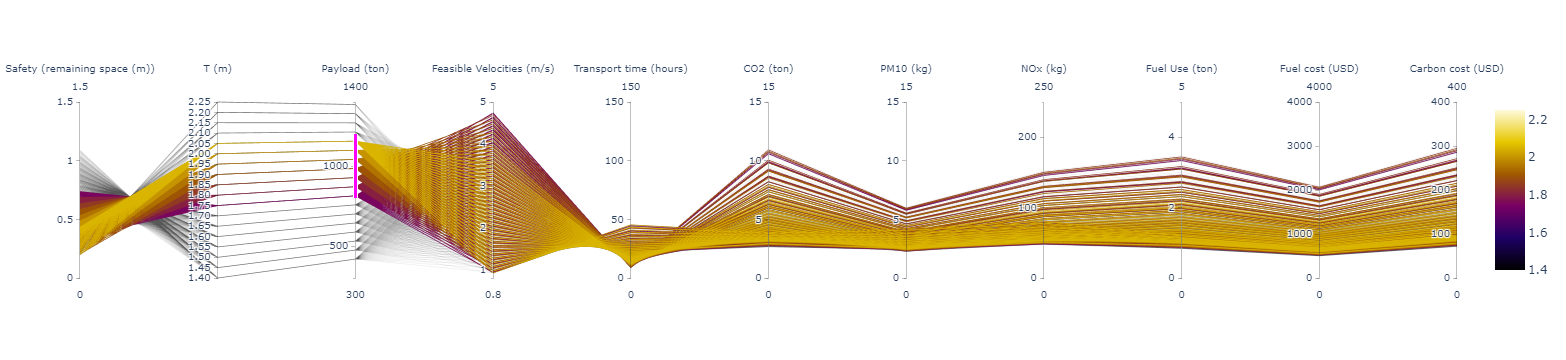

In [30]:

fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = strategies_df['T_strategy'],
                   colorscale = 'Electric',
                   # colorscale = 'armyrose',
                   showscale = True,
                   cmin = 2.25,
                   cmax = 1.4),
        dimensions = list([
            dict(range = [0,1.5],
                 visible = True,
                 label = 'Safety (remaining space (m))', values = strategies_df['Safety (remaining space (m))']),
            dict(tickvals = [1.40,1.45,1.50,1.55,1.60,1.65,1.70,1.75,1.80,1.85,1.90,
                            1.95,2.00,2.05,2.10,2.15,2.20,2.25],
                 ticktext = ['1.40','1.45','1.50','1.55','1.60','1.65','1.70','1.75','1.80','1.85','1.90',
                            '1.95','2.00','2.05','2.10','2.15','2.20','2.25'],
                 label = "T (m)", values = strategies_df['T_strategy']),
            dict(range = [300,1400],
                 constraintrange = [800,1200],
                 label = "Payload (ton)", values = strategies_df['Payload_strategy_tanker (ton)']),
            dict(range = [0.8,5],
                 # constraintrange = [2,3.5],
                 label = "Feasible Velocities (m/s)", values = strategies_df['v_feasible']),                       
             dict(range = [0,150],
                 label = 'Transport time (hours)', values = strategies_df['transport time (hours)']),
            dict(range = [0,15],
                 label = 'CO2 (ton)', values = strategies_df['CO2 (ton)']),
            dict(range = [0,15],                
                 label = 'PM10 (kg)', values = strategies_df['PM10 (kg)']),
            dict(range = [0,250],                 
                 label = 'NOx (kg)', values = strategies_df['NOx (kg)']),
            dict(range = [0,5],
                 # constraintrange = [8,20],
                 label = "Fuel Use (ton)", values = strategies_df['Fuel Use (ton)']),
            dict(range = [0,4000],                 
                 label = 'Fuel cost (USD)', values = strategies_df['Fuel cost (MGO_600USD/ton)']),
            dict(range = [0,400],
                 # constraintrange = [8,20],
                 label = 'Carbon cost (USD)', values = strategies_df['Carbon cost (EU_27USD/ton)']),            
           
        ]),
    )
)
fig.show()

In [26]:
# If you need to save this file as a standalone html file:
fig.write_html("C:/interactiveCharts/Strategies_and_policies.html")

In [27]:
%%html
<iframe src="C:/interactiveCharts/parallel-coordinate-plot-plotly.html" width="800" height="600" title="parallel coordinate chart with plotly" style="border:none"></iframe>